In [ ]:
import os
import sys
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image, ImageOps
from tensorflow.keras import layers
import tensorflow as tf
import random
import shutil
import cv2


In [ ]:
def exposure_loss(image, average_val=0.6):
    image = tf.reduce_mean(image, axis=3, keepdims=True)
    average = tf.nn.avg_pool2d(image, ksize=16, strides=16, padding="VALID")
    return tf.reduce_mean(tf.square(average - average_val))

In [ ]:
def illumination_smoothness_loss(img):
    batch_size = tf.shape(img)[0]
    height = tf.shape(img)[1]
    width = tf.shape(img)[2]
    count_horizontal = (tf.shape(img)[2] - 1) * tf.shape(img)[3]
    count_vertical = tf.shape(img)[2] * (tf.shape(img)[3] - 1)
    tv_horizontal = tf.reduce_sum(tf.square(img[:, 1:, :, :] - img[:, :height-1, :, :]))
    tv_vertical = tf.reduce_sum(tf.square(img[:, :, 1:, :] - img[:, :, :width-1, :]))
    batch_size = tf.cast(batch_size, dtype=tf.float32)
    count_horizontal = tf.cast(count_horizontal, dtype=tf.float32)
    count_vertical = tf.cast(count_vertical, dtype=tf.float32)
    return 2 * (tv_horizontal / count_horizontal + tv_vertical / count_vertical) / batch_size



In [ ]:
class SpatialConsistencyLossModified(tf.keras.losses.Loss):
    def __init__(self, **kwargs):
        super(SpatialConsistencyLossModified, self).__init__(reduction="none")

        self.left_filter = tf.constant([[[[0, 0, 0]], [[-1, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32)
        self.right_filter = tf.constant([[[[0, 0, 0]], [[0, 1, -1]], [[0, 0, 0]]]], dtype=tf.float32)
        self.up_filter = tf.constant([[[[0, -1, 0]], [[0, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32)
        self.down_filter = tf.constant([[[[0, 0, 0]], [[0, 1, 0]], [[0, -1, 0]]]], dtype=tf.float32)

    def call(self, true_values, predicted_values):
        original_mean = tf.reduce_mean(true_values, 3, keepdims=True)
        enhanced_mean = tf.reduce_mean(predicted_values, 3, keepdims=True)
        original_pool = tf.nn.avg_pool2d(original_mean, ksize=4, strides=4, padding="VALID")
        enhanced_pool = tf.nn.avg_pool2d(enhanced_mean, ksize=4, strides=4, padding="VALID")

        d_original_left = tf.nn.conv2d(original_pool, self.left_filter, strides=[1, 1, 1, 1], padding="SAME")
        d_original_right = tf.nn.conv2d(original_pool, self.right_filter, strides=[1, 1, 1, 1], padding="SAME")
        d_original_up = tf.nn.conv2d(original_pool, self.up_filter, strides=[1, 1, 1, 1], padding="SAME")
        d_original_down = tf.nn.conv2d(original_pool, self.down_filter, strides=[1, 1, 1, 1], padding="SAME")

        d_enhanced_left = tf.nn.conv2d(enhanced_pool, self.left_filter, strides=[1, 1, 1, 1], padding="SAME")
        d_enhanced_right = tf.nn.conv2d(enhanced_pool, self.right_filter, strides=[1, 1, 1, 1], padding="SAME")
        d_enhanced_up = tf.nn.conv2d(enhanced_pool, self.up_filter, strides=[1, 1, 1, 1], padding="SAME")
        d_enhanced_down = tf.nn.conv2d(enhanced_pool, self.down_filter, strides=[1, 1, 1, 1], padding="SAME")

        diff_left = tf.square(d_original_left - d_enhanced_left)
        diff_right = tf.square(d_original_right - d_enhanced_right)
        diff_up = tf.square(d_original_up - d_enhanced_up)
        diff_down = tf.square(d_original_down - d_enhanced_down)

        return diff_left + diff_right + diff_up + diff_down


In [ ]:
def color_constancy_loss(img):
    mean_rgb = tf.reduce_mean(img, axis=(1, 2), keepdims=True)
    mean_red, mean_green, mean_blue = mean_rgb[:, :, :, 0], mean_rgb[:, :, :, 1], mean_rgb[:, :, :, 2]
    diff_red_green = tf.square(mean_red - mean_green)
    diff_red_blue = tf.square(mean_red - mean_blue)
    diff_green_blue = tf.square(mean_green - mean_blue)
    return tf.sqrt(tf.square(diff_red_green) + tf.square(diff_red_blue) + tf.square(diff_green_blue))

In [ ]:
def build_dce_network():
    input_image = tf.keras.Input(shape=[None, None, 3])
    conv_layer1 = layers.Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same")(input_image)
    conv_layer2 = layers.Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same")(conv_layer1)
    conv_layer3 = layers.Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same")(conv_layer2)
    conv_layer4 = layers.Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same")(conv_layer3)

    concat1 = layers.Concatenate(axis=-1)([conv_layer4, conv_layer3])
    conv_layer5 = layers.Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same")(concat1)
    concat2 = layers.Concatenate(axis=-1)([conv_layer5, conv_layer2])
    conv_layer6 = layers.Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same")(concat2)
    concat3 = layers.Concatenate(axis=-1)([conv_layer6, conv_layer1])
    output_layer = layers.Conv2D(24, (3, 3), strides=(1, 1), activation="tanh", padding="same")(concat3)
    return tf.keras.Model(inputs=input_image, outputs=output_layer)


In [ ]:
class ZeroDCE(tf.keras.Model):
    def __init__(self, **kwargs):
        super(ZeroDCE, self).__init__(**kwargs)
        self.dce_net = build_dce_network()

    def compile(self, learning_rate, **kwargs):
        super(ZeroDCE, self).compile(**kwargs)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        self.spatial_constancy_loss = SpatialConsistencyLossModified(reduction="none")

    def enhance_image(self, data, output):
        r1, r2, r3, r4, r5, r6, r7, r8 = tf.split(output, num_or_size_splits=8, axis=-1)
        x = data + r1 * (tf.square(data) - data)
        x = x + r2 * (tf.square(x) - x)
        x = x + r3 * (tf.square(x) - x)
        x = x + r4 * (tf.square(x) - x)
        x = x + r5 * (tf.square(x) - x)
        x = x + r6 * (tf.square(x) - x)
        x = x + r7 * (tf.square(x) - x)
        enhanced_image = x + r8 * (tf.square(x) - x)
        return enhanced_image

    def call(self, inputs):
        dce_net_output = self.dce_net(inputs)
        return self.enhance_image(inputs, dce_net_output)

    def compute_losses(self, inputs, outputs):
        enhanced_image = self.enhance_image(inputs, outputs)
        loss_illumination = 200 * illumination_smoothness_loss(outputs)
        loss_spatial_constancy = tf.reduce_mean(self.spatial_constancy_loss(enhanced_image, inputs))
        loss_color_constancy = 5 * tf.reduce_mean(color_constancy_loss(enhanced_image))
        loss_exposure = 10 * tf.reduce_mean(exposure_loss(enhanced_image))
        total_loss = (
            loss_illumination
            + loss_spatial_constancy
            + loss_color_constancy
            + loss_exposure
        )
        return {
            "total_loss": total_loss,
            "illumination_smoothness_loss": loss_illumination,
            "spatial_constancy_loss": loss_spatial_constancy,
            "color_constancy_loss": loss_color_constancy,
            "exposure_loss": loss_exposure,
        }

    def train_step(self, data):
        with tf.GradientTape() as tape:
            outputs = self.dce_net(data)
            losses = self.compute_losses(data, outputs)
        gradients = tape.gradient(losses["total_loss"], self.dce_net.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.dce_net.trainable_weights))
        return losses

    def test_step(self, data):
        outputs = self.dce_net(data)
        return self.compute_losses(data, outputs)

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        """Save the weights of the DCE-Net."""
        self.dce_net.save_weights(filepath, overwrite=overwrite, save_format=save_format, options=options)

    def load_weights(self, filepath, by_name=False, skip_mismatch=False, options=None):
        """Load the weights of the DCE-Net."""
        self.dce_net.load_weights(filepath=filepath, by_name=by_name, skip_mismatch=skip_mismatch, options=options)


--2024-06-18 16:44:45--  https://github.com/kalpitkumawat/Image_denoising_kalpitk42/raw/main/zerodcemodel.h5
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kalpitkumawat/Image_denoising_kalpitk42/main/zerodcemodel.h5 [following]
--2024-06-18 16:44:45--  https://raw.githubusercontent.com/kalpitkumawat/Image_denoising_kalpitk42/main/zerodcemodel.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 348408 (340K) [application/octet-stream]
Saving to: ‘zerodcemodel.h5’

zerodcemodel.h5     100%[===================>] 340.24K  --.-KB/s    in 0.005s  

2024-06-18 16:44:45 (62.2 MB/s) - ‘zerodcemodel.

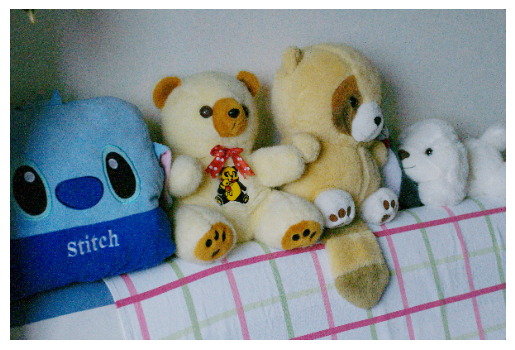

Processing image: /content/drive/MyDrive/Train/low/100.png


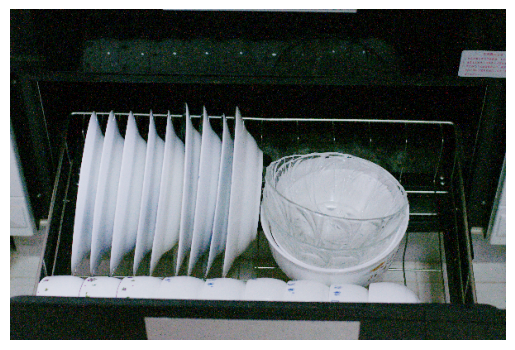

Processing image: /content/drive/MyDrive/Train/low/101.png


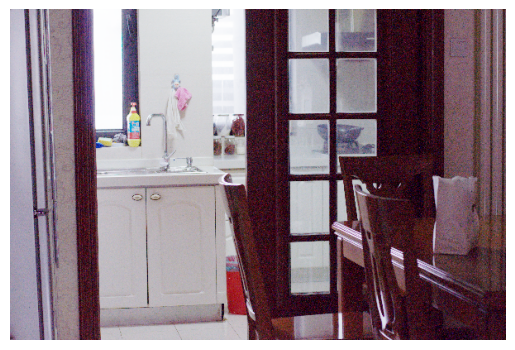

Processing image: /content/drive/MyDrive/Train/low/102.png


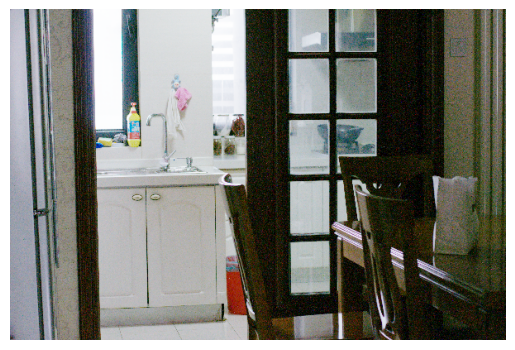

Processing image: /content/drive/MyDrive/Train/low/103.png


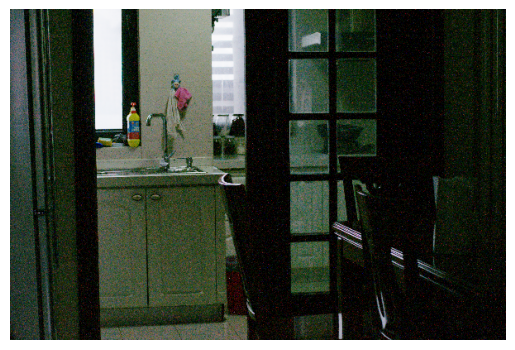

Processing image: /content/drive/MyDrive/Train/low/104.png


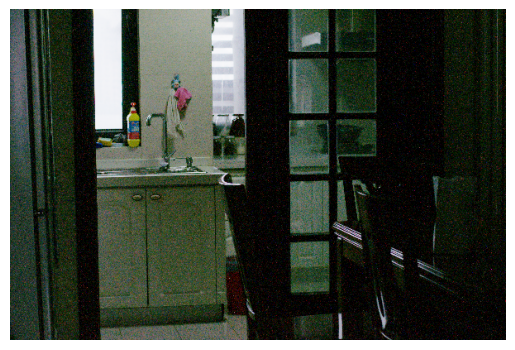

Processing image: /content/drive/MyDrive/Train/low/105.png


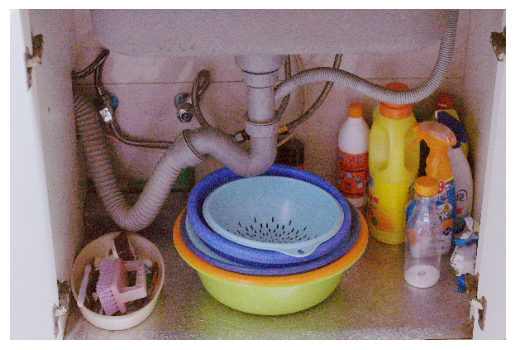

Processing image: /content/drive/MyDrive/Train/low/106.png


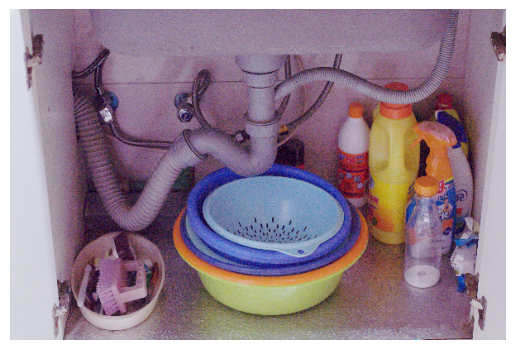

Processing image: /content/drive/MyDrive/Train/low/107.png


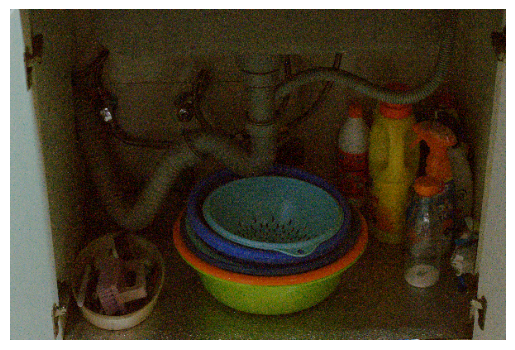

Processing image: /content/drive/MyDrive/Train/low/109.png


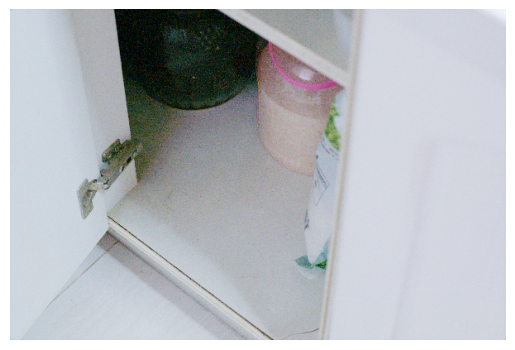

Processing image: /content/drive/MyDrive/Train/low/110.png


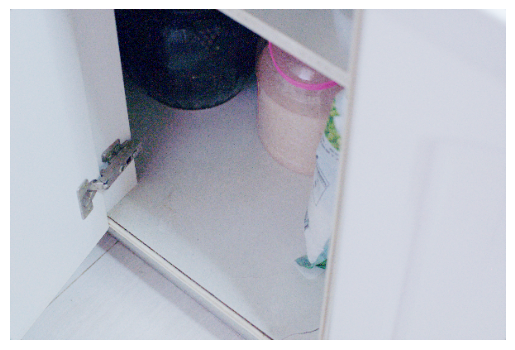

Processing image: /content/drive/MyDrive/Train/low/112.png


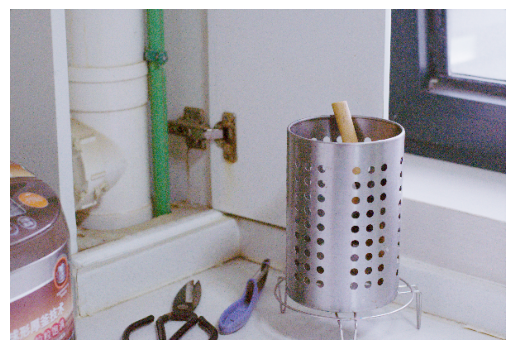

Processing image: /content/drive/MyDrive/Train/low/113.png


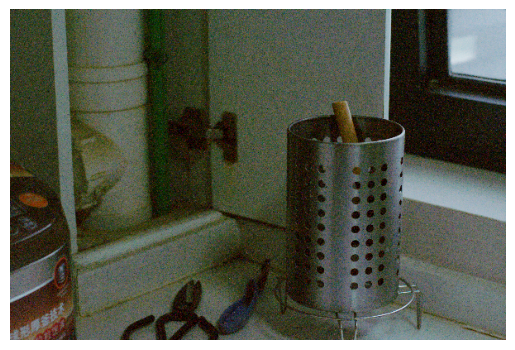

Processing image: /content/drive/MyDrive/Train/low/114.png


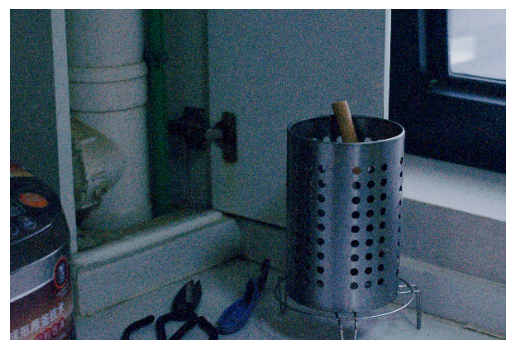

Processing image: /content/drive/MyDrive/Train/low/115.png


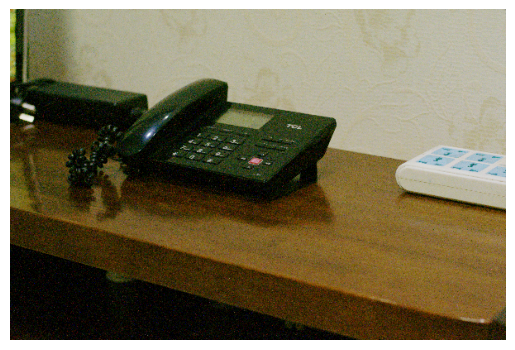

Processing complete.


In [ ]:
def infer(original_image):
    image = keras.preprocessing.image.img_to_array(original_image)
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    output_image = zero_dce_model(image)
    output_image = tf.cast((output_image[0, :, :, :] * 255), dtype=np.uint8)
    output_image = Image.fromarray(output_image.numpy())
    return output_image

!wget -O zerodcemodel.h5 https://github.com/kalpitkumawat/Image_denoising_kalpitk42/raw/main/zerodcemodel.h5
current_directory = os.getcwd()

# creating an instance of the model and laoding the weights
zero_dce_model = ZeroDCE()
weights = 'zerodcemodel.h5'
model_path = os.path.join(current_directory, weights)
print(f"Loading weights from: {model_path}")
zero_dce_model.load_weights(model_path)

#function to return the predicted image from the low light image
def infer(original_image):
    image = keras.preprocessing.image.img_to_array(original_image)
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    output_image = zero_dce_model(image)
    output_image = tf.cast((output_image[0, :, :, :] * 255), dtype=np.uint8)
    output_image = Image.fromarray(output_image.numpy())
    return output_image

test_imgs = sorted(glob(r'./test/low/*'))
print(f"Number of test images: {len(test_imgs)}")

save_dir = r'test/predicted'
path = os.path.join(current_directory, save_dir)

# Ensure the save directory exists if not then create
if not os.path.exists(path):
    os.makedirs(path)

print(f"Processing {len(test_imgs)} images...")
for val_image_file in test_imgs:
    print(f"Processing image: {val_image_file}")
    original_image = Image.open(val_image_file)
    enhanced_image = infer(original_image)

    file_name = os.path.basename(val_image_file)
    output_path = os.path.join(path, 'enhanced_' + file_name)
    enhanced_image.save(output_path)

    plt.imshow(enhanced_image)
    plt.axis('off')
    plt.show()

print("Processing complete.")